# Reproduction number of variants


In [1]:
import sys
sys.path.append("./covid19_inference")
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import os
import covid19_inference

n_threads = str(2) # per process
n_processes = 16
os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

# Load data variants
variants = pd.read_excel("./data/Chile_Variants.xlsx",sheet_name="Variants")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"

# Load casenumbers chile
jhu = covid19_inference.data_retrieval.JHU(True)
new_cases = jhu.get_new(country="Chile",data_begin=datetime(2021,1,4),data_end=datetime(2021,6,7))

# For now easy multiplication with fraction
fraction_variants = variants.divide(variants["N_total"],axis=0)
fraction_variants = fraction_variants.drop(columns=["N_total"])
fraction_variants.index = pd.to_datetime(fraction_variants.index + '-1', format='%V_%G-%u')
fraction_variants = fraction_variants.resample('D').ffill() # Fill forward

new_cases_variants = pd.DataFrame()
for variant in fraction_variants:
    new_cases_variants[variant] = new_cases*fraction_variants[variant]


INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


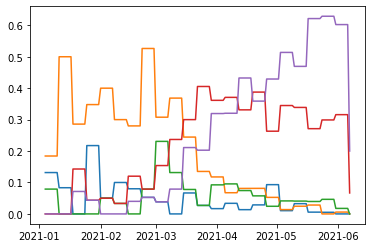

In [36]:
plt.plot(fraction_variants)

In [2]:
new_cases_variants

,B.1.1,B.1.1.348,B.1.1.7,C.37,P.1
date,,,,,
2021-01-04,322.368421,451.315789,193.421053,0.000000,0.000000
2021-01-05,323.684211,453.157895,194.210526,0.000000,0.000000
2021-01-06,313.421053,438.789474,188.052632,0.000000,0.000000
2021-01-07,485.921053,680.289474,291.552632,0.000000,0.000000
2021-01-08,553.289474,774.605263,331.973684,0.000000,0.000000
...,...,...,...,...,...
2021-06-03,0.000000,47.532164,142.596491,2566.736842,4895.812865
2021-06-04,0.000000,48.216374,144.649123,2603.684211,4966.286550
2021-06-05,0.000000,52.163743,156.491228,2816.842105,5372.865497


## Model variables

In [3]:
# Data begin/end
data_begin = new_cases_variants.index[0]
data_end = new_cases_variants.index[-1]

# Define changepoints (we define all vars to surpress the automatic prints)
change_points = [
    dict(
        relative_to_previous=False,
        pr_mean_date_transient=data_begin - timedelta(days=2),
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.12,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
        pr_median_transient_len=4,
        pr_factor_to_previous=1.0,
    ),
]
for day in pd.date_range(start=data_begin, end=data_end):
    if day.weekday() == 6:
        # Add cp
        change_points.append(
            dict(  # one possible change point every sunday
                pr_mean_date_transient=day,
                pr_sigma_date_transient=1.5,
                pr_sigma_lambda=0.2,  # wiggle compared to previous point
                relative_to_previous=True,
                pr_factor_to_previous=1.0,
                pr_sigma_transient_len=0.5,
                pr_median_transient_len=4,
                pr_median_lambda=0.125,
            )
        )
pr_delay = 10

params = {
    "new_cases_obs": new_cases_variants,
    "data_begin": data_begin,
    "fcast_len": 10,
    "diff_data_sim": 16,
    "N_population": np.ones(5)*19276715, # population chile
}

## Model definition

In [4]:
from covid19_inference import Cov19Model
from covid19_inference.model import (
    lambda_t_with_sigmoids,
    uncorrelated_prior_I,
    SIR,
    week_modulation,
    student_t_likelihood,
    delay_cases,
)
from pymc3 import Lognormal

with Cov19Model(**params) as this_model:
    """
    Basic spreading dynamics modeled alike to our publication:
    "Inferring change points in the spread of COVID-19
    reveals the effectiveness of interventions"
    see https://science.sciencemag.org/content/369/6500/eabb9789.full
    """
    # Get base reproduction number/spreading rate
    lambda_t_log = lambda_t_with_sigmoids(
        change_points_list=change_points,
        pr_median_lambda_0=1 / 8,
        hierarchical=False,
        name_lambda_t="base_lambda_t",
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    prior_I = uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )
    
    new_cases = SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


## sampling

In [5]:
multitrace, trace, multitrace_tuning, trace_tuning = covid19_inference.robust_sample(this_model, tune=1000, draws=1000, tuning_chains=30, 
                                        final_chains=8, cores=n_processes, return_tuning=True,
                                        max_treedepth=6)

WARNING  [pymc3] Tuning was enabled throughout the whole trace.
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (30 chains in 16 jobs)
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_raw_, weekend_factor_hc_L1_log, sigma_weekend_factor, delay_hc_L2_log_raw_, delay_hc_L1_log, delay_hc_sigma, I_begin_ratio_log, mu, transient_len_23_log_, transient_len_22_log_, transient_len_21_log_, transient_len_20_log_, transient_len_19_log_, transient_len_18_log_, transient_len_17_log_, transient_len_16_log_, transient_len_15_log_, transient_len_14_log_, transient_len_13_log_, transient_len_12_log_, transient_len_11_log_, transient_len_10_log_, transient_len_9_log_, transient_len_8_log_, transient_len_7_log_, transient_len_6_log_, transient_len_5_log_, transient_len_4_log_, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_23, transient_d

INFO     [pymc3] Sampling 30 chains for 1_000 tune and 0 draw iterations (30_000 + 0 draws total) took 3125 seconds.
INFO     [covid19_inference.sampling] Num chains kept: 24/30
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (8 chains in 16 jobs)
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_raw_, weekend_factor_hc_L1_log, sigma_weekend_factor, delay_hc_L2_log_raw_, delay_hc_L1_log, delay_hc_sigma, I_begin_ratio_log, mu, transient_len_23_log_, transient_len_22_log_, transient_len_21_log_, transient_len_20_log_, transient_len_19_log_, transient_len_18_log_, transient_len_17_log_, transient_len_16_log_, transient_len_15_log_, transient_len_14_log_, transient_len_13_log_, transient_len_12_log_, transient_len_11_log_, transient_len_10_log_, transient_len_9_log_, transient_len_8_log_, transient_len_7_log_, transient_len_6_log_, transient_len_5_log_, tran

INFO     [pymc3] Sampling 8 chains for 333 tune and 1_000 draw iterations (2_664 + 8_000 draws total) took 1983 seconds.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.9004402350976137, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.9054010438794607, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.9196258887066101, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameteriz

In [8]:
import arviz as az
rhat = az.rhat(trace)


/home/smohr/anaconda3/envs/soccer/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:                              (I_begin_dim_0: 5, I_begin_ratio_log_dim_0: 5, I_t_dim_0: 181, I_t_dim_1: 5, S_t_dim_0: 181, S_t_dim_1: 5, base_lambda_t_dim_0: 181, base_lambda_t_dim_1: 5, delay_hc_L2_dim_0: 5, delay_hc_L2_log_dim_0: 5, delay_hc_L2_log_raw__dim_0: 5, delayed_cases_dim_0: 181, delayed_cases_dim_1: 5, lambda_0_dim_0: 5, lambda_0_log__dim_0: 5, lambda_10_dim_0: 5, lambda_10_log__dim_0: 5, lambda_11_dim_0: 5, lambda_11_log__dim_0: 5, lambda_12_dim_0: 5, lambda_12_log__dim_0: 5, lambda_13_dim_0: 5, lambda_13_log__dim_0: 5, lambda_14_dim_0: 5, lambda_14_log__dim_0: 5, lambda_15_dim_0: 5, lambda_15_log__dim_0: 5, lambda_16_dim_0: 5, lambda_16_log__dim_0: 5, lambda_17_dim_0: 5, lambda_17_log__dim_0: 5, lambda_18_dim_0: 5, lambda_18_log__dim_0: 5, lambda_19_dim_0: 5, lambda_19_log__dim_0: 5, lambda_1_dim_0: 5, lambda_1_log__dim_0: 5, lambda_20_dim_0: 5, lambda_20_log__dim_0: 5, lambda_21_dim_0: 5, lambda_21_log__dim_0: 5, lambda_22_dim_0: 5, lambda_22_log__dim_0: 5, lambda_23_dim_0: 5, lambda_23_log__dim_0: 5, lambda_2_dim_0: 5, lambda_2_log__dim_0: 5, lambda_3_dim_0: 5, lambda_3_log__dim_0: 5, lambda_4_dim_0: 5, lambda_4_log__dim_0: 5, lambda_5_dim_0: 5, lambda_5_log__dim_0: 5, lambda_6_dim_0: 5, lambda_6_log__dim_0: 5, lambda_7_dim_0: 5, lambda_7_log__dim_0: 5, lambda_8_dim_0: 5, lambda_8_log__dim_0: 5, lambda_9_dim_0: 5, lambda_9_log__dim_0: 5, new_I_t_dim_0: 181, new_I_t_dim_1: 5, new_cases_dim_0: 181, new_cases_dim_1: 5, sigma_obs_dim_0: 5, transient_day_10_dim_0: 5, transient_day_11_dim_0: 5, transient_day_12_dim_0: 5, transient_day_13_dim_0: 5, transient_day_14_dim_0: 5, transient_day_15_dim_0: 5, transient_day_16_dim_0: 5, transient_day_17_dim_0: 5, transient_day_18_dim_0: 5, transient_day_19_dim_0: 5, transient_day_1_dim_0: 5, transient_day_20_dim_0: 5, transient_day_21_dim_0: 5, transient_day_22_dim_0: 5, transient_day_23_dim_0: 5, transient_day_2_dim_0: 5, transient_day_3_dim_0: 5, transient_day_4_dim_0: 5, transient_day_5_dim_0: 5, transient_day_6_dim_0: 5, transient_day_7_dim_0: 5, transient_day_8_dim_0: 5, transient_day_9_dim_0: 5, transient_len_10_dim_0: 5, transient_len_10_log__dim_0: 5, transient_len_11_dim_0: 5, transient_len_11_log__dim_0: 5, transient_len_12_dim_0: 5, transient_len_12_log__dim_0: 5, transient_len_13_dim_0: 5, transient_len_13_log__dim_0: 5, transient_len_14_dim_0: 5, transient_len_14_log__dim_0: 5, transient_len_15_dim_0: 5, transient_len_15_log__dim_0: 5, transient_len_16_dim_0: 5, transient_len_16_log__dim_0: 5, transient_len_17_dim_0: 5, transient_len_17_log__dim_0: 5, transient_len_18_dim_0: 5, transient_len_18_log__dim_0: 5, transient_len_19_dim_0: 5, transient_len_19_log__dim_0: 5, transient_len_1_dim_0: 5, transient_len_1_log__dim_0: 5, transient_len_20_dim_0: 5, transient_len_20_log__dim_0: 5, transient_len_21_dim_0: 5, transient_len_21_log__dim_0: 5, transient_len_22_dim_0: 5, transient_len_22_log__dim_0: 5, transient_len_23_dim_0: 5, transient_len_23_log__dim_0: 5, transient_len_2_dim_0: 5, transient_len_2_log__dim_0: 5, transient_len_3_dim_0: 5, transient_len_3_log__dim_0: 5, transient_len_4_dim_0: 5, transient_len_4_log__dim_0: 5, transient_len_5_dim_0: 5, transient_len_5_log__dim_0: 5, transient_len_6_dim_0: 5, transient_len_6_log__dim_0: 5, transient_len_7_dim_0: 5, transient_len_7_log__dim_0: 5, transient_len_8_dim_0: 5, transient_len_8_log__dim_0: 5, transient_len_9_dim_0: 5, transient_len_9_log__dim_0: 5, weekend_factor_hc_L2_dim_0: 5, weekend_factor_hc_L2_log_dim_0: 5, weekend_factor_hc_L2_log_raw__dim_0: 5)
Coordinates: (12/138)
  * lambda_0_log__dim_0                  (lambda_0_log__dim_0) int64 0 1 2 3 4
  * lambda_1_log__dim_0                  (lambda_1_log__dim_0) int64 0 1 2 3 4
  * lambda_2_log__dim_0                  (lambda_2_log__dim_0) int64 0 1 2 3 4
  * lambda_3_log__dim_0                  (lambda_3_log__dim_0) int64 0 1 2 3 4
  * lambda_4_log__dim_0                  (lambda_4_log__dim_0) int64 0 1 2 3 4
  * lambda_5_log__dim_

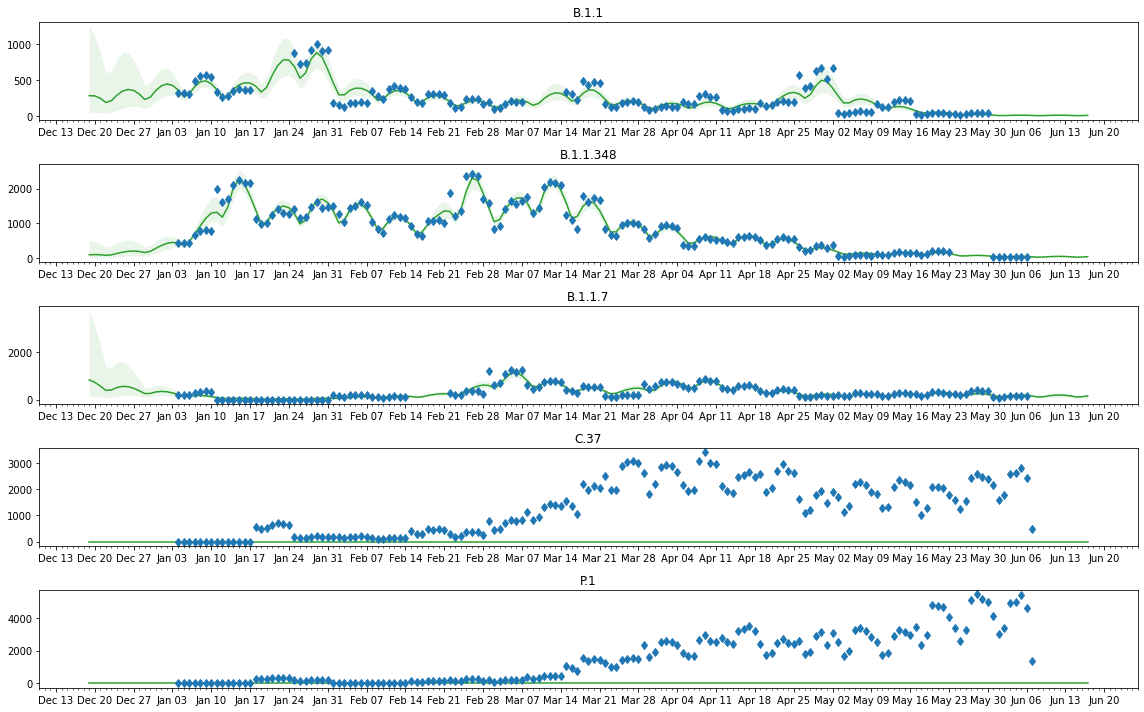

In [31]:
import matplotlib.pyplot as plt
import covid19_inference as cov19
import numpy as np
import pandas as pd

def plot_timeseries(trace, model, key, var=None):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
        
        
    fig, axes = plt.subplots(var.shape[-1],1,figsize=(16,2*var.shape[-1]))
    for c in range(var.shape[-1]):
        #For each country
        cov19.plot._timeseries(
            x=pd.date_range(model.sim_begin,model.sim_end),
            y=var[:,:,c],
            ax=axes[c],
            what="model")
    
    return axes

# Plot trace
axes = plot_timeseries(trace,this_model,"new_cases")
# Plot data
for c, ax in enumerate(axes):
    cov19.plot._timeseries(
        x=pd.date_range(this_model.data_begin,this_model.data_end),
        y=this_model.new_cases_obs[:,c],
        ax=ax,
        what="data")
    ax.set_title(variants.columns[c])
plt.tight_layout()

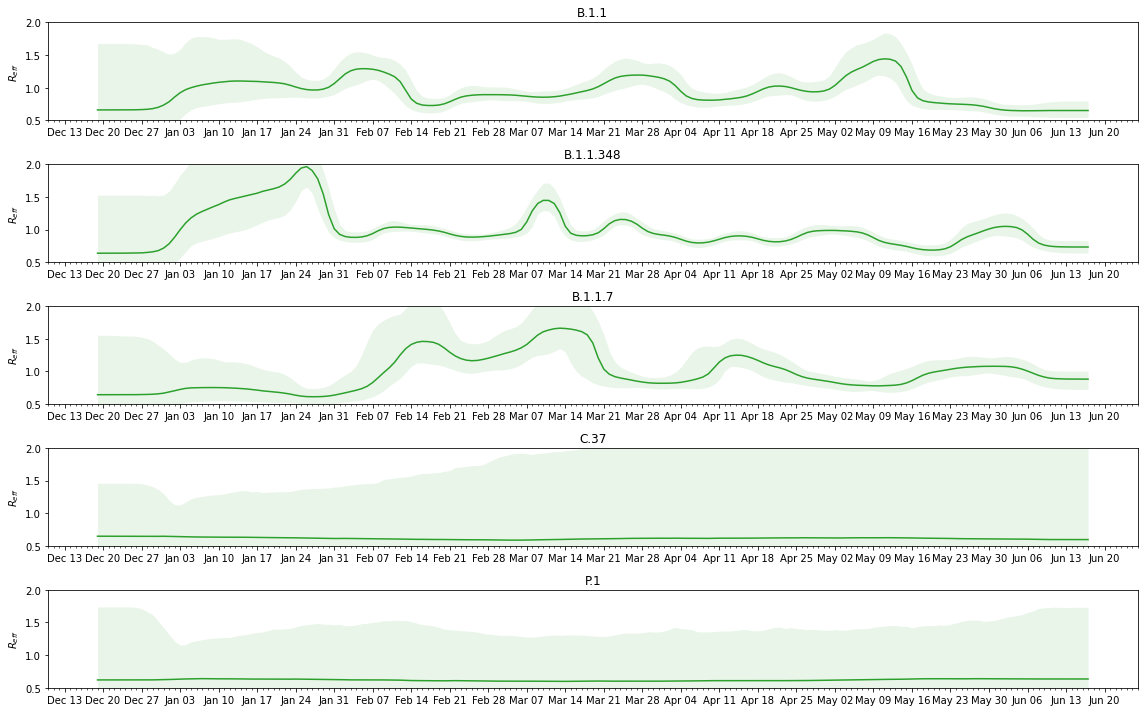

In [34]:
# Plot trace
R = (np.array(trace.posterior["base_lambda_t"]) - np.array(trace.posterior["mu"])[...,np.newaxis,np.newaxis] + 1)**4
R = R.reshape((R.shape[0]*R.shape[1],) + R.shape[2:])


axes = plot_timeseries(trace,this_model,"base_lambda_t",R)
for c, ax in enumerate(axes):
    ax.set_title(variants.columns[c])
    ax.set_ylabel("$R_{eff}$")
    ax.set_ylim(0.5,2)
plt.tight_layout()